In [1]:
include("methods_for_simulations.jl")





savefig_for_rejections_hipm_wow (generic function with 3 methods)

# How many permutations?

# Permutation or Boostrap ?


We compare boostrap and permutation approaches for HIPM and WoW. In particular we compare them by looking at Type I and Type II errors


Let us start with Type I error

In [2]:
function decide_boost(dist::Function, hier_sample_1::emp_ppm, hier_sample_2::emp_ppm, n_boostrap::Int, θ::Float64)
    distance_observed = dist(hier_sample_1, hier_sample_2)

    # now we obtain threshold via boostrap
    boostrap_samples = zeros(n_boostrap)

    a = minimum([hier_sample_1.a, hier_sample_2.a]) # since endpoints of space of observations for two hierarchical samples might not
                                                    # be same
    b = maximum([hier_sample_1.b, hier_sample_2.b])

    n = hier_sample_1.n
    m = hier_sample_1.m
    @assert n == hier_sample_2.n "number of rows for both hierarchical samples should be the same"
    @assert m == hier_sample_2.m "number of columns for both hierarchical samples should be the same"

    for i in 1:n_boostrap
        total_rows = vcat(hier_sample_1.atoms, hier_sample_2.atoms) # collect all rows
        indices_1 = sample(1:2*n, n; replace = true) # get random indices for rows from pooled sample 
        indices_2 = sample(1:2*n, n; replace = true) 
        atoms_1 = total_rows[indices_1,:]  # select the rows associated to random indices
        atoms_2 = total_rows[indices_2,:]  
       
        # define new hierarchical samples
        hier_sample_1_boostrap = emp_ppm(atoms_1, n, m, a, b)
        hier_sample_2_boostrap = emp_ppm(atoms_2, n, m, a, b)

        boostrap_samples[i] = dist(hier_sample_1_boostrap, hier_sample_2_boostrap)
    end

    threshold_boostrap = quantile(boostrap_samples, 1 - θ)
    return 1.0*(distance_observed > threshold_boostrap)
end



function decide_perm(dist::Function, hier_sample_1::emp_ppm, hier_sample_2::emp_ppm, n_permutations::Int, θ::Float64)
    distance_observed = dist(hier_sample_1, hier_sample_2)

    # now we obtain threshold via permutation
    permuted_samples = zeros(n_permutations)

    a = minimum([hier_sample_1.a, hier_sample_2.a]) # since endpoints of space of observations for two hierarchical samples might not
                                                    # be same
    b = maximum([hier_sample_1.b, hier_sample_2.b])

    n = hier_sample_1.n
    @assert n == hier_sample_2.n "number of rows for both hierarchical samples should be the same"

    for i in 1:n_permutations
        total_rows = vcat(hier_sample_1.atoms, hier_sample_2.atoms) # collect all rows
        random_indices = randperm(2*n) # indices to distribute rows to new hierarchical meausures
        
        # first n random rows will be to hirst permuted hierarchical measure, the rest to the second.
        atoms_1 = total_rows[random_indices[1:n],:] 
        atoms_2 = total_rows[random_indices[n+1:end],:] 

        # define new hierarchical samples
        hier_sample_1_permuted = emp_ppm(atoms_1, n, m, a, b)
        hier_sample_2_permuted = emp_ppm(atoms_2, n, m, a, b)

        permuted_samples[i] = dist(hier_sample_1_permuted, hier_sample_2_permuted)
    end

    threshold_permutation = quantile(permuted_samples, 1 - θ)
    return 1.0*(distance_observed > threshold_permutation)
end



decide_perm (generic function with 1 method)

In [3]:
function rejection_rate_boost_vs_perm(q_1::PPM, q_2::PPM, n::Int, m::Int, n_boostrap::Int, n_permutations::Int, θ::Float64, S::Int64)
    # This function obtains rejection rate for pair of laws of random probability measures. It obtains these rates for each
    # distance function (WoW, HIPM) and each method of obtaining thresholds (boostrap, permutation).
    # Rejection rate is number of times we reject H_0 per generated hierarchical samples divided by number of generated hierarchical samples S.
    
    # Input: 
    #   q_1: law of RPM
    #   q_2: law of RPM
    #   n: number rows in hierarchical sample
    #   m: number of columns in hierarchical sample
    #   θ: significance level
    #   S: number of times we simulate hierarchical samples to estimate Type I error
    rej_rates_wow_boost = 0.0
    rej_rates_wow_perm = 0.0    
    rej_rates_dlip_boost = 0.0
    rej_rates_dlip_perm = 0.0

    for s in 1:S
        # generate hierarchical samples
        hier_sample_1, hier_sample_2 = generate_emp(q_1, n, m), generate_emp(q_2, n, m)

        # Record decisions 
        rej_rates_wow_boost += decide_boost(ww, hier_sample_1, hier_sample_2, n_boostrap, θ) 
        rej_rates_wow_perm += decide_perm(ww, hier_sample_1, hier_sample_2, n_permutations, θ)

        rej_rates_dlip_boost += decide_boost(dlip, hier_sample_1, hier_sample_2, n_boostrap, θ)
        rej_rates_dlip_perm += decide_perm(dlip, hier_sample_1, hier_sample_2, n_permutations, θ)
    end

    return [rej_rates_wow_boost/S, rej_rates_wow_perm/S, rej_rates_dlip_boost/S, rej_rates_dlip_perm/S]
end

rejection_rate_boost_vs_perm (generic function with 1 method)

we consider several laws of random probability measure. So we will have several Type I errors per distance function and perm/boostrap.

Then we can plot 4 curves per each law of random probability measures.

In [ ]:
# Define parameters for hierarchical sample, methods 

n = 1
m = 1

n_boostrap = 1
n_permutation = n_boostrap


θ = 0.05

S = 1 # number of simulations to estimate rejection rate

rejection_rate_boost_vs_perm(pair_of_laws::Tuple{PPM,PPM}) = rejection_rate_boost_vs_perm(pair_of_laws[1], pair_of_laws[2], n, m, n_boostrap, n_permutation, θ, S)




rejection_rate_boost_vs_perm (generic function with 2 methods)

In [5]:
# Let us define several pairs of Dirichlet Processes

a, b = 0.0, 1.0
P_0 = ()->rand(Beta(1,1))
α = 1.0
q_1 = DP(α, P_0, a, b)


βs = [1,2,3,4,5]

n_laws = 5

laws = []
for i in 1:n_laws
    q_1 = DP(α, P_0, a, b)
    P_2 = ()->rand(Beta(1,1))
    q_2 = DP(α, P_2, a, b)
    push!(laws, (q_1,q_2))
end







In [6]:
laws

5-element Vector{Any}:
 (DP(1.0, var"#20#21"(), 0.0, 1.0), DP(1.0, var"#22#23"(), 0.0, 1.0))
 (DP(1.0, var"#20#21"(), 0.0, 1.0), DP(1.0, var"#22#23"(), 0.0, 1.0))
 (DP(1.0, var"#20#21"(), 0.0, 1.0), DP(1.0, var"#22#23"(), 0.0, 1.0))
 (DP(1.0, var"#20#21"(), 0.0, 1.0), DP(1.0, var"#22#23"(), 0.0, 1.0))
 (DP(1.0, var"#20#21"(), 0.0, 1.0), DP(1.0, var"#22#23"(), 0.0, 1.0))

In [7]:
laws[1]

(DP(1.0, var"#20#21"(), 0.0, 1.0), DP(1.0, var"#22#23"(), 0.0, 1.0))

In [8]:
[rejection_rate_boost_vs_perm(laws[i]) for i in 1:n_laws]

5-element Vector{Vector{Float64}}:
 [1.0, 1.0, 1.0, 0.5]
 [1.0, 1.0, 0.5, 1.0]
 [1.0, 0.5, 0.0, 1.0]
 [1.0, 0.5, 0.5, 0.0]
 [0.5, 0.0, 1.0, 0.0]

In [10]:
rejections = zeros(n_laws, 4)

for i in 1:n_laws
    rejections[i,:] = rejection_rate_boost_vs_perm(laws[i])
end







In [11]:
rejections

5×4 Matrix{Float64}:
 0.5  0.5  1.0  0.0
 1.0  0.0  0.5  0.0
 1.0  0.0  0.5  0.5
 0.5  0.0  0.0  0.5
 1.0  0.5  0.0  0.0

In [ ]:
typeof(rejections[1])

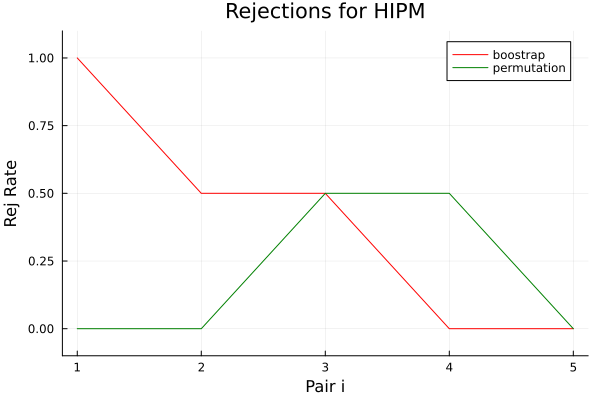

In [ ]:
# We plot rejection rates seperately for WoW and HIPM



fig_wow = plot(title = "Rejections for WoW", xlabel = "Pair i", ylabel = "Rej Rate", ylims = (-0.1, 1.1))
plot!(fig_wow, 1:n_laws, rejections[:,1], label = "boostrap", color = "brown")
plot!(fig_wow, 1:n_laws, rejections[:,2], label = "permutation", color = "brown")


fig_hipm = plot(title = "Rejections for HIPM", xlabel = "Pair i", ylabel = "Rej Rate", ylims = (-0.1, 1.1))
plot!(fig_hipm, 1:n_laws, rejections[:,3], label = "boostrap", color = "red")
plot!(fig_hipm, 1:n_laws, rejections[:,4], label = "permutation", color = "green")





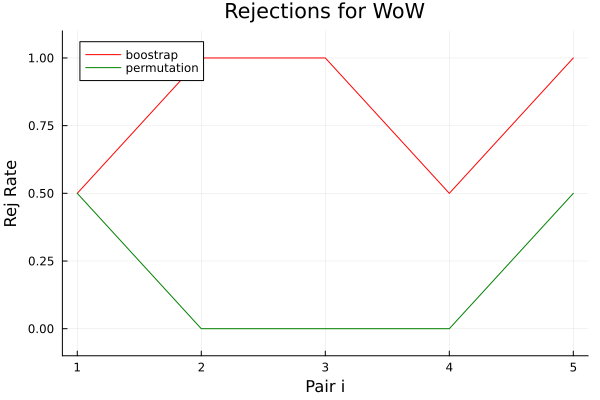

In [14]:
fig_wow

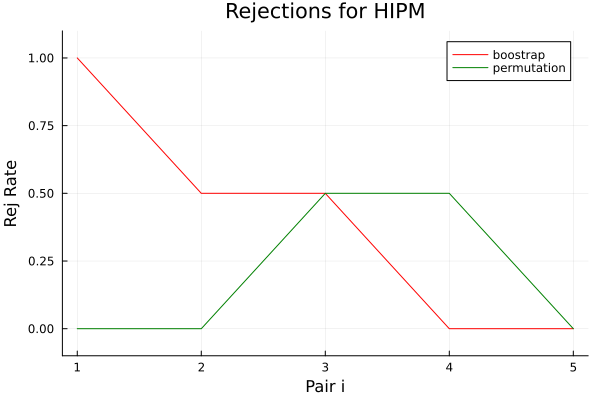

In [13]:
fig_hipm